In [2]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
import pandas as pd
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import xml.etree.ElementTree as ET
from lxml import etree
from scipy.sparse import hstack
import numpy as np
import warnings
import spacy
from os.path import join

nlp = spacy.load('en_core_web_sm')

path_train = "/content/drive/My Drive/Colab Notebooks/data/semeval_16/ABSA16_Laptops_Train_English_SB2.xml"
path_test = "/content/drive/My Drive/Colab Notebooks/data/semeval_16/EN_LAPT_SB2_TESTB.xml"

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
data_path = "/content/drive/My Drive/Colab Notebooks/data/semeval_16/"

In [0]:
#xml parser
def get_list(path):
    tree=ET.parse(path)
    root = tree.getroot()
    text_list = []
    opinion_list = []
    for review in root.findall('Review'):
        text_string=""
        opinion_inner_list=[]
        for sent in review.findall('./sentences/sentence'):
            text_string= text_string+ " "+ sent.find('text').text
        text_list.append(text_string)
        for opinion in review.findall('./Opinions/Opinion'):
            opinion_dict = {
                opinion.get('category').replace('#','_'): opinion.get('polarity')
            }
            opinion_inner_list.append(opinion_dict)
        opinion_list.append(opinion_inner_list)
    return text_list,opinion_list
#get_list(path_train)

In [0]:
#Selecting only 20 most common aspect.
def get_most_common_aspect(opinion_list):
    import nltk
    opinion= []
    for inner_list in opinion_list:
        for _dict in inner_list:
            for key in _dict:
                opinion.append(key)
    most_common_aspect = [k for k,v in nltk.FreqDist(opinion).most_common(20)]
    return most_common_aspect

In [0]:
#generate data frame
def get_data_frame(text_list,opinion_list,most_common_aspect):
    data={'Review':text_list}
    df = pd.DataFrame(data)
    if opinion_list:
        for inner_list in opinion_list:
            for _dict in inner_list:
                for key in _dict:
                    if key in most_common_aspect:
                        df.loc[opinion_list.index(inner_list),key]=_dict[key]
    return df

In [0]:
#generate data frame for aspect extraction task
def get_aspect_data_frame(df,most_common_aspect):
    for common_aspect in most_common_aspect:
        df[common_aspect]=df[common_aspect].replace(['positive','negative','neutral','conflict'],[1,1,1,1])
    df = df.fillna(0)
    return df

In [0]:
def get_positive_data_frame(df,most_common_aspect):
    for common_aspect in most_common_aspect:
        df[common_aspect]=df[common_aspect].replace(['positive'],[1])
        df[common_aspect]=df[common_aspect].replace(['negative','neutral','conflict'],[0,0,0])
    df = df.fillna(0)
    return df

In [0]:
def get_negative_data_frame(df,most_common_aspect):
    for common_aspect in most_common_aspect:
        df[common_aspect]=df[common_aspect].replace(['negative'],[1])
        df[common_aspect]=df[common_aspect].replace(['positive','neutral','conflict'],[0,0,0])
    df = df.fillna(0)
    return df

In [0]:
def get_neutral_data_frame(df,most_common_aspect):
    for common_aspect in most_common_aspect:
        df[common_aspect]=df[common_aspect].replace(['neutral','conflict'],[1,1])
        df[common_aspect]=df[common_aspect].replace(['negative','positive'],[0,0])
    df = df.fillna(0)
    return df

In [0]:
def posTag(review):
    doc = nlp(review)
    tagged_text_list=[]
    for token in doc:
        tagged_text_list.append((token, token.pos_))
    return tagged_text_list
#posTag("this is random text")

In [0]:
#Filter the word with tag- noun,adjective,verb,adverb
def filterTag(tagged_review):
    final_text_list=[]
    for text_list in tagged_review:
        final_text=[]
        for word,tag in text_list:
            if tag in ['NN','NNS','NNP','NNPS','RB','RBR','RBS','JJ','JJR','JJS','VB','VBD','VBG','VBN','VBP','VBZ']:
                final_text.append(word)
        final_text_list.append(' '.join(final_text))
    return final_text_list

In [0]:
def get_dict_aspect(y,most_common_aspect):
    position=[]
    for innerlist in y:
        position.append([i for i, j in enumerate(innerlist) if j == 1])
    sorted_common=sorted(most_common_aspect)
    dict_aspect=[]
    for innerlist in position:
        inner_dict={}
        for word in sorted_common:
            if sorted_common.index(word) in innerlist:
                inner_dict[word]= 5
            else:
                inner_dict[word]=0
        dict_aspect.append(inner_dict)
    return dict_aspect

In [0]:
#Stage 1:
#Making list to train
train_text_list,train_opinion_list = get_list(path_train)
most_common_aspect = get_most_common_aspect(train_opinion_list)

In [0]:
#This takes time to tag. Already tagged and saved. So, loading file ...
#tagged_text_list_train=posTag(train_text_list)
#joblib.dump(tagged_text_list_train, 'tagged_text_list_train.pkl')
tagged_text_list_train=joblib.load('/content/drive/My Drive/Colab Notebooks/tagged_text_list_train.pkl')

In [0]:
#train list after filter
final_train_text_list=filterTag(tagged_text_list_train)

In [18]:
#get data frame
df_train = get_data_frame(final_train_text_list,train_opinion_list,most_common_aspect)
df_train_aspect = get_aspect_data_frame(df_train,most_common_aspect)
df_train_aspect = df_train_aspect.reindex_axis(sorted(df_train_aspect.columns), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
#Similar for test list
test_text_list,test_opinion_list = get_list(path_test)

In [0]:
#tagged_text_list_test=posTag(test_text_list)
#joblib.dump(tagged_text_list_test, 'tagged_text_list_test.pkl')
tagged_text_list_test=joblib.load('/content/drive/My Drive/Colab Notebooks/tagged_text_list_test.pkl')

In [0]:
final_test_text_list=filterTag(tagged_text_list_test)

In [22]:
df_test = get_data_frame(final_test_text_list,test_opinion_list,most_common_aspect)
df_test_aspect = get_aspect_data_frame(df_test,most_common_aspect)
df_test_aspect = df_test_aspect.reindex_axis(sorted(df_test_aspect.columns), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
df_test_aspect.replace('',1, inplace=True)

In [0]:
#Sort the data frame according to aspect's name and separate data(X) and target(y)
#df_train_aspect = df_train_aspect.sample(frac=1).reset_index(drop=True) #For randoming
X_train= df_train_aspect.Review
y_train = df_train_aspect.drop('Review',1)

#df_test_aspect = df_test_aspect.sample(frac=1).reset_index(drop=True) #For randoming
X_test = df_test_aspect.Review
y_test = df_test_aspect.drop('Review',1)

In [0]:
#Change y_train to numpy array
import numpy as np
y_train = np.asarray(y_train, dtype=np.int64)
y_test = np.asarray(y_test, dtype=np.int64)

In [26]:
%cd /content/drive/My\ Drive/Colab Notebooks/ 

/content/drive/My Drive/Colab Notebooks


In [42]:
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!pip install .

fatal: destination path 'fastText' already exists and is not an empty directory.
/content/drive/My Drive/Colab Notebooks/fastText
Processing /content/drive/My Drive/Colab Notebooks/fastText
  Stored in directory: /tmp/pip-ephem-wheel-cache-_1q3dvsu/wheels/df/47/19/b7f3fb1f41bb433ace24a8b518bf1f72fff37c1444a6f2d85e
Successfully built fasttext


In [27]:
!pwd

/content/drive/My Drive/Colab Notebooks


##**2.3 Generate word embeddings using pre-trained fasttext**

In [0]:
import fastText

In [0]:
ft_model = fastText.load_model('/content/drive/My Drive/Colab Notebooks/cc.en.300.bin')

In [0]:
#X_train_dtm = fastText(X_train, size=300, window=5, min_count=5, workers=4,sg=1)
#X_test_dtm = FastText(X_test, size=300, window=5, min_count=5, workers=4,sg=1)

In [0]:
def write_binary(generated_embed, operation, emb_type, pre_trained):
  if pre_trained == True:
    f_path = data_path + "laptop_" + operation + "_" + emb_type + "_pre" + ".pkl"
  else:
    f_path = data_path + "laptop_" + operation + "_" + emb_type + ".pkl"
  joblib.dump(generated_embed, f_path)

In [0]:
#def get_vecs_pretrained(embedding_type, operation):
#  embed = []
#  unique_words = []
#  if operation == "train":
#    X = X_train
#  else:
#    X = X_test 
#  i = 0
#  for sent in X:
#    words = sent.split()
#    for w in words:
#      unique_words.append(w)
#      if embedding_type == 'fasttext'and w not in unique_words:
#          embedding = ft_model.get_word_vector(w)
#          unique_words.append(w)
#      embed.append(embedding)
#      i += 1
#  write_binary(embed, operation, embedding_type, True)
#  return embed

In [0]:
def get_vecs_pretrained(embedding_type, operation):
  embed = []
  if operation == "train":
    X = X_train
  else:
    X = X_test 
  for sent in X:
    if embedding_type == 'fasttext':
        embedding = ft_model.get_word_vector(sent)
    embed.append(embedding)
  write_binary(embed, operation, embedding_type, False)
  return embed

In [0]:
X_train_dtm = get_vecs_pretrained('fasttext', "train")

In [0]:
X_test_dtm = get_vecs_pretrained('fasttext', "test")

## **3. Training - I. SVC, II. Linear SVC, III. SGD**

In [0]:
#Create various models. These are multi-label models.
#nb_classif = OneVsRestClassifier(MultinomialNB()).fit(X_train_dtm, y_train)
C = 1.0 #SVregularization parameter
svc = OneVsRestClassifier(svm.SVC(kernel='linear', C=C)).fit(X_train_dtm, y_train)
lin_svc = OneVsRestClassifier(svm.LinearSVC(C=C)).fit(X_train_dtm, y_train)
sgd = OneVsRestClassifier(SGDClassifier()).fit(X_train_dtm,y_train)

In [0]:
#Predict the test data using classifiers
#y_pred_class = nb_classif.predict(X_test_dtm)
y_pred_class_svc = svc.predict(X_test_dtm)
y_pred_class_lin_svc = lin_svc.predict(X_test_dtm)
y_pred_class_sgd = sgd.predict(X_test_dtm)

## **4. Evaluation**

In [0]:
#Following code to test metrics of all aspect extraction classifiers
from sklearn import metrics

In [154]:
#print(metrics.accuracy_score(y_test,y_pred_class))
print(metrics.accuracy_score(y_test,y_pred_class_svc))
print(metrics.accuracy_score(y_test,y_pred_class_lin_svc))
print(metrics.accuracy_score(y_test,y_pred_class_sgd))

0.0125
0.0125
0.0125


In [155]:
#print(metrics.precision_score(y_test,y_pred_class,average='micro'))
print(metrics.precision_score(y_test,y_pred_class_svc,average='micro'))
print(metrics.precision_score(y_test,y_pred_class_lin_svc,average='micro'))
print(metrics.precision_score(y_test,y_pred_class_sgd,average='micro'))

1.0
1.0
0.625


In [156]:
#print(metrics.recall_score(y_test,y_pred_class,average='micro'))
print(metrics.recall_score(y_test,y_pred_class_svc,average='micro'))
print(metrics.recall_score(y_test,y_pred_class_lin_svc,average='micro'))
print(metrics.recall_score(y_test,y_pred_class_sgd,average='micro'))

0.1937046004842615
0.19612590799031476
0.36319612590799033


In [157]:
#print(metrics.f1_score(y_test,y_pred_class,average='micro'))
print(metrics.f1_score(y_test,y_pred_class_svc,average='micro'))
print(metrics.f1_score(y_test,y_pred_class_lin_svc,average='micro'))
print(metrics.f1_score(y_test,y_pred_class_sgd,average='micro'))

0.32454361054766734
0.32793522267206476
0.45941807044410415


In [158]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #print(metrics.classification_report(y_test, y_pred_class))
    print(metrics.classification_report(y_test, y_pred_class_svc))
    print(metrics.classification_report(y_test, y_pred_class_lin_svc))
    print(metrics.classification_report(y_test, y_pred_class_sgd))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        21
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00        39
           8       1.00      1.00      1.00        80
           9       0.00      0.00      0.00        24
          10       0.00      0.00      0.00        46
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00        27
          13       0.00      0.00      0.00        29
          14       0.00      0.00      0.00        30
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         9
          17       0.00    

# **Training dataset and aspects with fasttext and glove**

In [75]:
!wget https://github.com/facebookresearch/fastText/archive/v0.2.0.zip
!unzip v0.2.0.zip
%cd fastText-0.2.0
!make

--2019-06-04 18:15:50--  https://github.com/facebookresearch/fastText/archive/v0.2.0.zip
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/v0.2.0 [following]
--2019-06-04 18:15:51--  https://codeload.github.com/facebookresearch/fastText/zip/v0.2.0
Resolving codeload.github.com (codeload.github.com)... 192.30.253.120
Connecting to codeload.github.com (codeload.github.com)|192.30.253.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v0.2.0.zip’

v0.2.0.zip              [  <=>               ]   4.10M  10.5MB/s    in 0.4s    

2019-06-04 18:15:52 (10.5 MB/s) - ‘v0.2.0.zip’ saved [4304799]

Archive:  v0.2.0.zip
7842495a4d64c7a3bb4339d45d6e64321d002ed8
   creating: fastText-0.2.0/
   creating: fastText-0.2.0/.circleci/
  inflating: fa

In [78]:
%cd ..

/content/drive/My Drive/Colab Notebooks


In [0]:
with open('final_train_lap_text_list.txt', 'w') as f:
    for item in final_train_text_list:
        f.write("%s\n" % item)

In [82]:
!./fastText-0.2.0/fasttext skipgram -input final_train_lap_text_list.txt -output lap_train_fasttext

Read 0M words
Number of words:  692
Number of labels: 0
Progress: 100.0% words/sec/thread:     927 lr:  0.000000 loss:  2.837866 ETA:   0h 0m


In [83]:
!head -n 4 lap_train_fasttext.vec

692 100
is 0.048605 0.089964 -0.19173 0.17796 0.16871 0.081048 0.042013 0.12641 0.013913 0.036666 -0.016862 -0.043748 -0.098599 0.15753 -0.0072601 0.0040584 -0.070804 0.12455 -0.13194 0.15266 0.059934 -0.038058 0.10256 0.12049 -0.23423 0.027832 0.30983 0.10331 -0.098036 0.20962 0.13913 0.38013 0.15401 0.092495 0.15794 -0.14718 0.14494 0.014829 -0.18482 0.14736 0.060854 0.032302 -0.20278 -0.17558 0.05908 0.0067925 0.087013 0.066245 -0.042679 -0.072516 -0.0057534 -0.18203 -0.039749 0.01164 -0.012033 0.00048501 0.03497 0.1547 -0.029176 0.01594 -0.23832 0.27767 0.15675 0.10022 0.086229 0.026763 0.094115 0.16339 -0.2382 -0.16304 0.24004 -0.13151 -0.42724 -0.14775 0.011885 0.095501 -0.008131 -0.030775 -0.085245 0.3064 -0.14926 -0.26184 -0.064748 -0.041313 0.22018 0.088797 0.17517 0.13287 0.12684 0.32542 -0.079685 -0.12319 0.0096853 -0.24497 -0.0045057 -0.27031 -0.049547 -0.28373 0.0031253 0.20304 
</s> 0.057321 0.094223 -0.18317 0.17303 0.17416 0.092356 0.032796 0.12837 0.011657 0.030783 -0.

In [0]:
ft_model_own = fastText.load_model('/content/drive/My Drive/Colab Notebooks/lap_train_fasttext.bin')

In [0]:
#def get_vecs_own(embedding_type, operation):
#  embed = []
#  if operation == "train":
#    X = X_train
#  else:
#    X = X_test 
#  i = 0
#  for sent in X:
#    words = sent.split()
#    for w in words:
#      if embedding_type == 'fasttext':
#          embedding = ft_model_own.get_word_vector(w)
#      embed.append(embedding)
#      i += 1
#  write_binary(embed, operation, embedding_type, False)
#  return embed

In [0]:
def get_vecs_own(embedding_type, operation):
  embed = []
  if operation == "train":
    X = X_train
  else:
    X = X_test 
  for sent in X:
    if embedding_type == 'fasttext':
        embedding = ft_model_own.get_word_vector(sent)
    embed.append(embedding)
  write_binary(embed, operation, embedding_type, False)
  return embed

In [0]:
X_train_ft = get_vecs_own('fasttext', "train")

In [0]:
X_test_ft = get_vecs_own('fasttext', "test")

In [0]:
# Declaring two empty lists. One for words and one for their corresponding vector representation

words = []
vecs = []

# Getting word and corresponding vector from each line of the model.vec file generated by fasttext 

import codecs # To open the file in specific mode

with codecs.open('/content/drive/My Drive/Colab Notebooks/lap_train_fasttext.vec', 'r', 'utf-8') as f_in:
    vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in f_in])
    
 
# Populating the two lists. Need to convert vector values from string to numpy array 

for i in range(10,len(vocabulary)): # Usually skip first 10 words becuase they might be garbage values.
    words.append(vocabulary[i])
    x = wv[i]
    vecs.append(np.fromstring(x,dtype='float32',sep=' '))   
    # np.fromstring takes string values and converts to float32 with space as a separator

In [0]:
# Carrying out Singular Value Decomposition

U, s, Vh = np.linalg.svd(vecs,full_matrices=False)

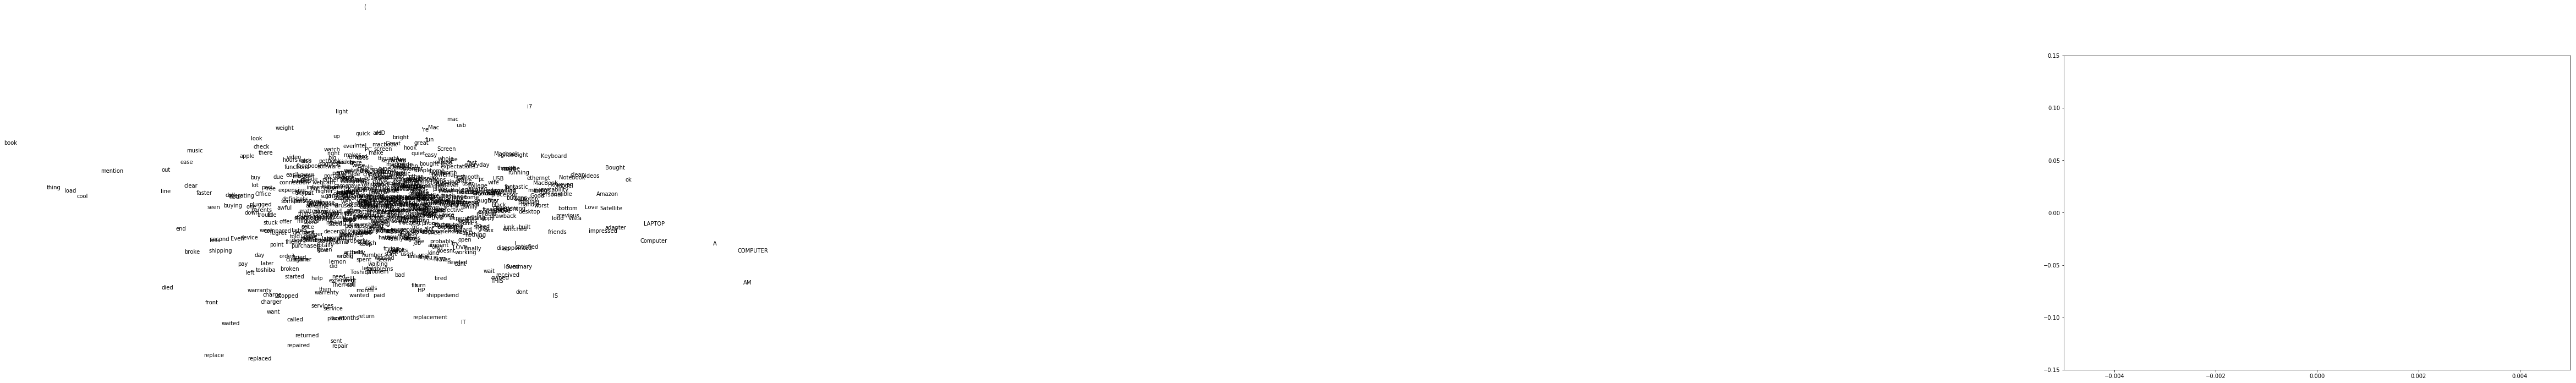

In [167]:
import matplotlib.pyplot as plt

# Plotting words and their vector representations

for i in range(len(words)):
        fig = plt.gcf()
        fig.set_size_inches(16.5, 10.5)
        plt.text(U[i,0], U[i,1], words[i])
        plt.xlim((-0.005,0.005))
        plt.ylim((-0.15,0.15))
        
plt.savefig('lap_train_fasttext_viz.jpg')